K-Means


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

print("Libraries loaded successfully.")




Libraries loaded successfully.


Data Loading & Cleaning

In [ ]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

C:\Users\jon.palacios\AppData\Local\Temp\ipykernel_24464\3298266864.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.log1p(X[col])


Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
911559,1.116555,1.370600,0.352392,-0.620125,-0.063804,0.865346
791532,0.092824,0.259636,1.877364,-0.279232,-0.131117,-0.271504
910002,-0.853963,-1.133636,0.564643,-0.468896,-0.265742,0.751661
186474,0.959450,1.233096,-0.771263,-1.357419,-0.669618,-0.669402
825623,1.100172,0.971938,1.263387,0.004248,0.878572,0.353764


Elbow Method

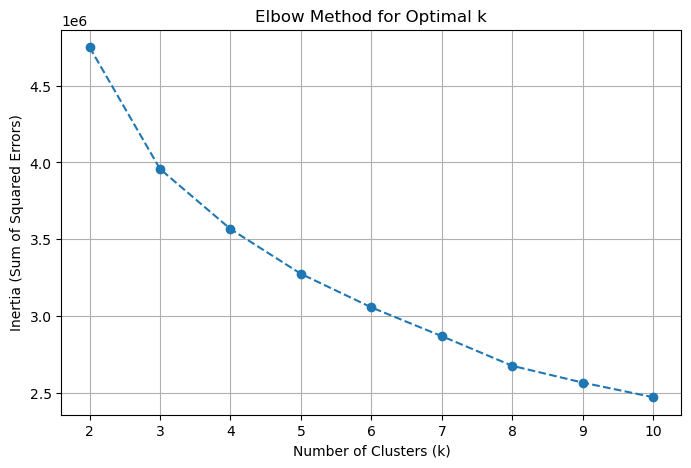

In [8]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()